# Project

## 전처리

In [188]:
import glob
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
# print("Examples:\n", raw_corpus[500:1000])

데이터 크기: 187088


괄호 안에 있는 내용을 삭제하고 싶다. 또한 어퍼스트로피는 살리는 방향으로 전처리를 진행한다.

In [206]:
# 입력된 문장을
#     0. 괄호 안에 있는 내용을 없앱니다
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     2-1. '뒤에 공백 하나를 넣습니다
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿,'가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. (' )로 시작하는 경우 지웁니다
#     7. '앞에 공백이 있는 경우 함께 지웁니다.
#     8. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_lyrics(sentence):
    sentence = re.sub(r'\([^)]*\)',r'',sentence)
    sentence = re.sub(r'\[[^)]*\]',r'',sentence )
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r"([\'])", r"\1 ", sentence)  # 2-1
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿\']+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = re.sub(r"^\' ", r'', sentence)  # 6
    sentence = re.sub(r" \'", r"", sentence)  # 7
    if sentence:
        sentence = '<start> ' + sentence + ' <end>' # 8
        return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_lyrics("why don' t you go ' ' ' out  and play"))

<start> why don' t you go out and play <end>


In [207]:
# 여기에 정제된 문장을 모을겁니다
lyric_corpus = []

for lyric in raw_corpus:
    # 정제를 합니다
    preprocessed_lyric = preprocess_lyrics(lyric)
    # 우리가 원하지 않는 문장은 건너뜁니다
    if not preprocessed_lyric: continue
    lyric_corpus.append(preprocessed_lyric)    
# 정제된 결과를 20개만 확인해보죠
lyric_corpus[1000:1020]

["<start> i' m talking about happy people <end>",
 '<start> they keep the world dancing , dancing , dancing <end>',
 '<start> happy people <end>',
 '<start> keep the world stepping , stepping , stepping <end>',
 '<start> nothing but happy people <end>',
 '<start> keeps the world grooving , grooving uh uh uh , alright , uh huh <end>',
 '<start> now if you want to step <end>',
 '<start> you gotta play it by the rules <end>',
 '<start> you gotta do what i do <end>',
 '<start> when i do , what i do <end>',
 '<start> if you want to step <end>',
 '<start> you gotta play it by the rules <end>',
 '<start> you gotta do what i do <end>',
 '<start> when i do , what i do <end>',
 '<start> now step to the left , step to the right <end>',
 '<start> spin around and bring it down tonight <end>',
 '<start> bring it on up , move in close <end>',
 '<start> let me see you and your partner stroll step to the left , step to the right <end>',
 '<start> spin around and bring it down tonight <end>',
 '<start> 

In [7]:
len(lyric_corpus)

172709

20000 사이즈의 단어장을 만든다. 대부분의 모델은 이 단어장을 기반으로 학습을 진행했다.
truncating='post'로 설정한 이유는 15보다 긴 문장을 걸러내기 위해서이다.

In [8]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 20000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 20000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15, truncating='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(lyric_corpus)

[[  2   6 190 ...   0   0   0]
 [  2   9 542 ...   0   0   0]
 [  2  50  38 ...   0   0   0]
 ...
 [  2 310 153 ...   0   0   0]
 [  2  10 163 ...   0   0   0]
 [  2 177  15 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f1596041090>


In [208]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 5: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the


In [209]:
for i, x in enumerate(tensor):
    print(x)
    if i>10: break

[  2   6 190   7 899   4 101   6  72  50   3   0   0   0]
[  2   9 542   7   4  43  43   3   0   0   0   0   0   0]
[   2   50   38  100 9732    3    0    0    0    0    0    0    0    0]
[   2  142  274   77  104 3381    9  318    7   50    3    0    0    0]
[   2    8   49   18   59   94   72  145    4    9 2377   13   12   87]
[   2    7  177   15 1634   13   50    4    8    7 1689  177   15  443]
[    2    58    17 11556    79    21  1298    17   709    28    11     3
     0     0]
[   2    6   51   35  190   13  899  899   28   11   12 1298   17  899]
[   2   12 1298   17  899   28    7    3    0    0    0    0    0    0]
[   2   12 1298   17  899   28    7    3    0    0    0    0    0    0]
[   2   12 1298   17  899   28    7   96   11    4  369   17   21 1252]
[  2  50  21 273  26  12 989  43 250  13  26  50   3   0]


마지막 토큰이 end나 pad가 아니라면 긴 문장이므로, 제거한다.

In [9]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
# 마지막 토큰이 0이나 3이 아니라면 maxlen보다 긴 것입니다. (truncating = 'post')
# 따라서 마지막 토큰이 0이거나 3인것만 선택합니다.
short_tensor = np.array([x for i, x in  enumerate(tensor) if x[-1]==0 or x[-1]==3])
print(short_tensor.shape)
src_input = short_tensor[:,:-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = short_tensor[:,1:]    

print(src_input[0])
print(tgt_input[0])

(154437, 15)
[  2   6 190   7 899   4 101   6  72  50   3   0   0   0]
[  6 190   7 899   4 101   6  72  50   3   0   0   0   0]


In [10]:
from sklearn.model_selection import train_test_split


enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=36)
print(len(enc_train), len(enc_val))

123549 30888


In [16]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 20000개와, 여기 포함되지 않은 0:<pad>를 포함하여 20001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [17]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

학습을 진행한다. validation data와 metric를 지정하지 않아서 logging이 제대로 되지 않았다.

In [214]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

In [120]:
model.fit(dataset, epochs=10)

Epoch 1/10
482/482 [==============================] - 203s 411ms/step - loss: 4.2561
Epoch 2/10
482/482 [==============================] - 199s 412ms/step - loss: 3.1333
Epoch 3/10
482/482 [==============================] - 200s 415ms/step - loss: 2.9649
Epoch 4/10
482/482 [==============================] - 202s 418ms/step - loss: 2.8370
Epoch 5/10
482/482 [==============================] - 202s 418ms/step - loss: 2.7317
Epoch 6/10
482/482 [==============================] - 201s 417ms/step - loss: 2.6301
Epoch 7/10
482/482 [==============================] - 201s 417ms/step - loss: 2.5398
Epoch 8/10
482/482 [==============================] - 201s 416ms/step - loss: 2.4646
Epoch 9/10
482/482 [==============================] - 201s 416ms/step - loss: 2.3819
Epoch 10/10
482/482 [==============================] - 201s 416ms/step - loss: 2.3097


In [12]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 128
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 20000개와, 여기 포함되지 않은 0:<pad>를 포함하여 20001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset_128 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_128 = dataset_128.shuffle(BUFFER_SIZE)
dataset_128 = dataset_128.batch(BATCH_SIZE, drop_remainder=True)
dataset_128

<BatchDataset shapes: ((128, 14), (128, 14)), types: (tf.int32, tf.int32)>

In [13]:
embedding_size = 256 + 128
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [149]:
model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, epochs=10)

Epoch 1/10
965/965 [==============================] - 236s 240ms/step - loss: 3.6370
Epoch 2/10
965/965 [==============================] - 235s 244ms/step - loss: 2.7836
Epoch 3/10
965/965 [==============================] - 237s 245ms/step - loss: 2.5102
Epoch 4/10
965/965 [==============================] - 237s 245ms/step - loss: 2.2566
Epoch 5/10
965/965 [==============================] - 237s 245ms/step - loss: 2.0428
Epoch 6/10
965/965 [==============================] - 237s 245ms/step - loss: 1.8585
Epoch 7/10
965/965 [==============================] - 237s 245ms/step - loss: 1.7056
Epoch 8/10
965/965 [==============================] - 237s 245ms/step - loss: 1.5683
Epoch 9/10
965/965 [==============================] - 236s 245ms/step - loss: 1.4466
Epoch 10/10
965/965 [==============================] - 236s 244ms/step - loss: 1.3430


학습이 잘 되었다. 가중치를 저장한다.

In [152]:
# model.save_weights(os.getenv('HOME') + '/aiffel/lyricist/my_checkpoint')

In [191]:
embedding_size = 256 + 128
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
model.load_weights(os.getenv('HOME') + '/aiffel/lyricist/my_checkpoint')

In [193]:
lyricist = model

In [216]:
lyricist.compile(loss=loss, optimizer=optimizer)
lyricist.evaluate(val_set)

232/232 [==============================] - 18s 73ms/step - loss: 1.6236


1.6247577667236328

## 1.62의 loss를 얻었다. 모델을 시험해보자

In [194]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

In [195]:
generate_text(lyricist, tokenizer, init_sentence="<start> what can i do", max_len=20)

'<start> what can i do for you ? <end> '

In [222]:
generate_text(lyricist, tokenizer, init_sentence="<start> golden", max_len=20)

'<start> golden tone <end> '

In [197]:
generate_text(lyricist, tokenizer, init_sentence="<start> kiss you", max_len=20)

'<start> kiss you taste you all night <end> '

In [221]:
generate_text(lyricist, tokenizer, init_sentence="<start> satisfy", max_len=20)

'<start> satisfy the world <end> '

In [199]:
generate_text(lyricist, tokenizer, init_sentence="<start> don'", max_len=20)

"<start> don' t you know that you' re toxic ? <end> "

In [173]:
generate_text(lyricist, tokenizer, init_sentence="<start> when we' re ", max_len=20)

"<start> when we' re kissing <end> "

In [230]:
generate_text(lyricist, tokenizer, init_sentence="<start> apple rolls ", max_len=20)

'<start> apple rolls everywhere <end> '

In [218]:
generate_text(lyricist, tokenizer, init_sentence="<start> sweet", max_len=20)

'<start> sweet revenge <end> '

In [219]:
generate_text(lyricist, tokenizer, init_sentence="<start> await", max_len=20)

'<start> await the night , <end> '

In [224]:
generate_text(lyricist, tokenizer, init_sentence="<start> be crazy", max_len=20)

'<start> be crazy , oh <end> '

In [225]:
generate_text(lyricist, tokenizer, init_sentence="<start> steal your heart ", max_len=20)

'<start> steal your heart to me <end> '

In [226]:
generate_text(lyricist, tokenizer, init_sentence="<start> in the forest ", max_len=20)

'<start> in the forest of the night <end> '

In [231]:
generate_text(lyricist, tokenizer, init_sentence="<start> fallin'", max_len=20)

"<start> fallin' , fallin' , fallin' in love <end> "

# 다른 모델 탐색 (실패의 기록)

가사가 좀 밋밋한 것 같다. 수동으로 하이퍼파라미터를 조정해본다

In [19]:
# 중복이 있는 train set
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 128
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 20000개와, 여기 포함되지 않은 0:<pad>를 포함하여 20001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset_128 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_128 = dataset_128.shuffle(BUFFER_SIZE)
dataset_128 = dataset_128.batch(BATCH_SIZE, drop_remainder=True)
dataset_128

<BatchDataset shapes: ((128, 14), (128, 14)), types: (tf.int32, tf.int32)>

In [22]:
# 중복이 있는 validation set
BUFFER_SIZE = len(enc_val)
BATCH_SIZE = 128
steps_per_epoch = len(enc_val) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 20000개와, 여기 포함되지 않은 0:<pad>를 포함하여 20001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)
dataset_val

<BatchDataset shapes: ((128, 14), (128, 14)), types: (tf.int32, tf.int32)>

이때부터 val_loss를 모니터하고 Early stopping을 시작했다

In [22]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [65]:
embedding_size = 64
hidden_size = 96 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [66]:
optimizer = tf.keras.optimizers.Adam(lr=0.0006)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 47s 47ms/step - loss: 5.3092 - val_loss: 3.6969
Epoch 2/10
965/965 [==============================] - 45s 46ms/step - loss: 3.6281 - val_loss: 3.5064
Epoch 3/10
965/965 [==============================] - 45s 46ms/step - loss: 3.4790 - val_loss: 3.4183
Epoch 4/10
965/965 [==============================] - 45s 46ms/step - loss: 3.3804 - val_loss: 3.3485
Epoch 5/10
965/965 [==============================] - 45s 46ms/step - loss: 3.3094 - val_loss: 3.2877
Epoch 6/10
965/965 [==============================] - 45s 46ms/step - loss: 3.2520 - val_loss: 3.2419
Epoch 7/10
965/965 [==============================] - 45s 46ms/step - loss: 3.1951 - val_loss: 3.1953
Epoch 8/10
965/965 [==============================] - 45s 46ms/step - loss: 3.1381 - val_loss: 3.1542
Epoch 9/10
965/965 [==============================] - 45s 46ms/step - loss: 3.1043 - val_loss: 3.1154
Epoch 10/10
965/965 [==============================] - 45s 46ms/step - loss: 3.052

과적합은 해소되었다. 데이터를 추가할 수 없으므로 모델이 표현할 수 있는 규모를 조금만 늘려보자

In [67]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_80_120.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [70]:
embedding_size = 80
hidden_size = 120
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.0024)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 52s 51ms/step - loss: 4.4529 - val_loss: 3.4989
Epoch 2/10
965/965 [==============================] - 49s 51ms/step - loss: 3.4455 - val_loss: 3.3248
Epoch 3/10
965/965 [==============================] - 49s 51ms/step - loss: 3.2575 - val_loss: 3.1439
Epoch 4/10
965/965 [==============================] - 49s 51ms/step - loss: 3.0777 - val_loss: 3.0289
Epoch 5/10
965/965 [==============================] - 50s 51ms/step - loss: 2.9535 - val_loss: 2.9528
Epoch 6/10
965/965 [==============================] - 49s 51ms/step - loss: 2.8602 - val_loss: 2.8880
Epoch 7/10
965/965 [==============================] - 49s 51ms/step - loss: 2.7780 - val_loss: 2.8398
Epoch 8/10
965/965 [==============================] - 49s 51ms/step - loss: 2.6948 - val_loss: 2.7998
Epoch 9/10
965/965 [==============================] - 49s 51ms/step - loss: 2.6215 - val_loss: 2.7683
Epoch 10/10
965/965 [==============================] - 49s 51ms/step - loss: 2.564

In [71]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_100_150.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
embedding_size = 100
hidden_size = 150
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.0024)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 63s 63ms/step - loss: 4.3710 - val_loss: 3.4930
Epoch 2/10
965/965 [==============================] - 61s 63ms/step - loss: 3.4257 - val_loss: 3.2751
Epoch 3/10
965/965 [==============================] - 61s 63ms/step - loss: 3.2091 - val_loss: 3.0994
Epoch 4/10
965/965 [==============================] - 61s 63ms/step - loss: 3.0307 - val_loss: 2.9856
Epoch 5/10
965/965 [==============================] - 61s 63ms/step - loss: 2.9016 - val_loss: 2.9067
Epoch 6/10
965/965 [==============================] - 61s 63ms/step - loss: 2.8047 - val_loss: 2.8494
Epoch 7/10
965/965 [==============================] - 61s 63ms/step - loss: 2.7163 - val_loss: 2.8005
Epoch 8/10
965/965 [==============================] - 61s 63ms/step - loss: 2.6371 - val_loss: 2.7647
Epoch 9/10
965/965 [==============================] - 61s 63ms/step - loss: 2.5559 - val_loss: 2.7322
Epoch 10/10
965/965 [==============================] - 61s 63ms/step - loss: 2.478

In [74]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_200_400.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
embedding_size = 200
hidden_size = 400
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.0072)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 113s 115ms/step - loss: 3.6884 - val_loss: 2.9519
Epoch 2/10
965/965 [==============================] - 111s 115ms/step - loss: 2.8534 - val_loss: 2.8140
Epoch 3/10
965/965 [==============================] - 111s 115ms/step - loss: 2.6506 - val_loss: 2.7357
Epoch 4/10
965/965 [==============================] - 111s 115ms/step - loss: 2.5014 - val_loss: 2.6888
Epoch 5/10
965/965 [==============================] - 111s 115ms/step - loss: 2.3753 - val_loss: 2.6614
Epoch 6/10
965/965 [==============================] - 111s 115ms/step - loss: 2.2660 - val_loss: 2.6407
Epoch 7/10
965/965 [==============================] - 111s 115ms/step - loss: 2.1689 - val_loss: 2.6423


In [109]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_200_600.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
embedding_size = 200
hidden_size = 600
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.0144)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 154s 157ms/step - loss: 4.0236 - val_loss: 3.0613
Epoch 2/10
965/965 [==============================] - 152s 158ms/step - loss: 2.9867 - val_loss: 2.9665
Epoch 3/10
965/965 [==============================] - 153s 158ms/step - loss: 2.8567 - val_loss: 2.9198
Epoch 4/10
262/965 [=======>......................] - ETA: 1:42 - loss: 2.7690

KeyboardInterrupt: 

In [78]:
lyricist2 = model

In [100]:
generate_text(lyricist2, tokenizer, init_sentence="<start> blood on", max_len=20)

'<start> blood on the collar , the night is beginning to come <end> '

In [101]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_200_600.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
embedding_size = 200
hidden_size = 600
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.00216)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 155s 158ms/step - loss: 3.9500 - val_loss: 3.1063
Epoch 2/10
965/965 [==============================] - 153s 158ms/step - loss: 3.0137 - val_loss: 2.9290
Epoch 3/10
965/965 [==============================] - 153s 158ms/step - loss: 2.8005 - val_loss: 2.8084
Epoch 4/10
965/965 [==============================] - 153s 159ms/step - loss: 2.6278 - val_loss: 2.7219
Epoch 5/10
965/965 [==============================] - 153s 159ms/step - loss: 2.4618 - val_loss: 2.6535
Epoch 6/10
965/965 [==============================] - 153s 158ms/step - loss: 2.3137 - val_loss: 2.6031
Epoch 7/10
965/965 [==============================] - 153s 158ms/step - loss: 2.1821 - val_loss: 2.5699
Epoch 8/10
965/965 [==============================] - 153s 159ms/step - loss: 2.0673 - val_loss: 2.5536
Epoch 9/10
965/965 [==============================] - 153s 158ms/step - loss: 1.9644 - val_loss: 2.5394
Epoch 10/10
965/965 [==============================] - 153s 158m

In [102]:
lyricist3 = model

In [107]:
generate_text(lyricist3, tokenizer, init_sentence="<start> kill", max_len=20)

'<start> kill the same time i had it <end> '

overfitting이다

In [110]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_350_450.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
embedding_size = 350
hidden_size = 450
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.00072)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 133s 135ms/step - loss: 4.3528 - val_loss: 3.4319
Epoch 2/10
965/965 [==============================] - 131s 136ms/step - loss: 3.3587 - val_loss: 3.1843
Epoch 3/10
965/965 [==============================] - 131s 136ms/step - loss: 3.1172 - val_loss: 3.0351
Epoch 4/10
965/965 [==============================] - 131s 136ms/step - loss: 2.9625 - val_loss: 2.9361
Epoch 5/10
965/965 [==============================] - 131s 136ms/step - loss: 2.8421 - val_loss: 2.8610
Epoch 6/10
965/965 [==============================] - 131s 136ms/step - loss: 2.7422 - val_loss: 2.7971
Epoch 7/10
965/965 [==============================] - 131s 136ms/step - loss: 2.6494 - val_loss: 2.7472
Epoch 8/10
965/965 [==============================] - 131s 136ms/step - loss: 2.5490 - val_loss: 2.7016
Epoch 9/10
965/965 [==============================] - 131s 136ms/step - loss: 2.4582 - val_loss: 2.6662
Epoch 10/10
965/965 [==============================] - 131s 136m

In [111]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_350_450.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
embedding_size = 350
hidden_size = 450
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.00288)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 134s 135ms/step - loss: 3.8903 - val_loss: 3.0706
Epoch 2/10
965/965 [==============================] - 131s 135ms/step - loss: 2.9793 - val_loss: 2.9120
Epoch 3/10
965/965 [==============================] - 131s 135ms/step - loss: 2.7956 - val_loss: 2.8228
Epoch 4/10
965/965 [==============================] - 131s 135ms/step - loss: 2.6568 - val_loss: 2.7577
Epoch 5/10
965/965 [==============================] - 131s 135ms/step - loss: 2.5250 - val_loss: 2.7035
Epoch 6/10
965/965 [==============================] - 131s 135ms/step - loss: 2.4090 - val_loss: 2.6657
Epoch 7/10
965/965 [==============================] - 130s 135ms/step - loss: 2.2994 - val_loss: 2.6421
Epoch 8/10
965/965 [==============================] - 131s 135ms/step - loss: 2.2030 - val_loss: 2.6264
Epoch 9/10
965/965 [==============================] - 131s 135ms/step - loss: 2.1236 - val_loss: 2.6191
Epoch 10/10
965/965 [==============================] - 131s 135m

In [25]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_350_900.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
embedding_size = 350
hidden_size = 900
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam(lr=0.00288)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

Epoch 1/10
965/965 [==============================] - 251s 255ms/step - loss: 3.7840 - val_loss: 3.0046
Epoch 2/10
965/965 [==============================] - 251s 260ms/step - loss: 2.8879 - val_loss: 2.7914
Epoch 3/10
965/965 [==============================] - 252s 261ms/step - loss: 2.6087 - val_loss: 2.6600
Epoch 4/10
965/965 [==============================] - 251s 260ms/step - loss: 2.3582 - val_loss: 2.5694
Epoch 5/10
965/965 [==============================] - 251s 260ms/step - loss: 2.1468 - val_loss: 2.5093
Epoch 6/10
965/965 [==============================] - 251s 260ms/step - loss: 1.9620 - val_loss: 2.4807
Epoch 7/10
965/965 [==============================] - 251s 260ms/step - loss: 1.8089 - val_loss: 2.4631
Epoch 8/10
965/965 [==============================] - 251s 260ms/step - loss: 1.6720 - val_loss: 2.4606
Epoch 9/10
965/965 [==============================] - 250s 259ms/step - loss: 1.5505 - val_loss: 2.4632


여러 하이퍼파라미터를 시도했지만 2.2의 val_loss를 얻을 수 없었다.

# Project with Ray

모델 생성을 체계화하고 하이퍼파라미터 튜닝을 도와주는 모듈 ray를 이용한다.

In [232]:
import glob
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
# print("Examples:\n", raw_corpus[500:1000])

데이터 크기: 187088


In [8]:
# 입력된 문장을
#     0. 괄호 안에 있는 내용을 없앱니다
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     2-1. '뒤에 공백 하나를 넣습니다
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿,'가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. (' )로 시작하는 경우 지웁니다
#     7. '앞에 공백이 있는 경우 함께 지웁니다.
#     8. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_lyrics(sentence):
    sentence = re.sub(r'\([^)]*\)',r'',sentence)
    sentence = re.sub(r'\[[^)]*\]',r'',sentence )
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r"([\'])", r"\1 ", sentence)  # 2-1
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿\']+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = re.sub(r"^\' ", r'', sentence)  # 6
    sentence = re.sub(r" \'", r"", sentence)  # 7
    if sentence:
        sentence = '<start> ' + sentence + ' <end>' # 8
        return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_lyrics(""))

None


In [9]:
# 여기에 정제된 문장을 모을겁니다
lyric_corpus = []

for lyric in raw_corpus:
    # 정제를 합니다
    preprocessed_lyric = preprocess_lyrics(lyric)
    # 우리가 원하지 않는 문장은 건너뜁니다
    if not preprocessed_lyric: continue
    lyric_corpus.append(preprocessed_lyric) 

In [54]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 20000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 20000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=14, truncating='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(lyric_corpus)

[[  2   6 190 ...   0   0   0]
 [  2   9 542 ...   0   0   0]
 [  2  50  38 ...   0   0   0]
 ...
 [  2 310 153 ...   0   0   0]
 [  2  10 163 ...   3   0   0]
 [  2 177  15 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f2190ec24d0>


In [34]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
# 마지막 토큰이 0이나 3이 아니라면 maxlen보다 긴 것입니다. (truncating = 'post')
# 따라서 마지막 토큰이 0이거나 3인것만 선택합니다.
short_tensor = np.array([x for i, x in  enumerate(tensor) if x[-1]==0 or x[-1]==3])
print(short_tensor.shape)
src_input = short_tensor[:,:-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = short_tensor[:,1:]    

print(src_input[0])
print(tgt_input[0])

(148652, 14)
[  2   6 190   7 899   4 101   6  72  50   3   0   0]
[  6 190   7 899   4 101   6  72  50   3   0   0   0]


In [37]:
from sklearn.model_selection import train_test_split


enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=36)
print(len(enc_train), len(enc_val))

118921 29731


In [57]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

model과 dataset을 생성하는 함수를 제작한다

In [55]:
def create_model(*, embedding_size, hidden_size, lr, vocab_size=tokenizer.num_words+1):
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture'''
    
    optimizer = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
    reduction='none'
    )
    
    model = TextGenerator(vocab_size, embedding_size, hidden_size)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [32]:
def create_dataset(enc, dec, *, batch_size=128, seed=36):
    buffer_size = len(enc)
    steps_per_epoch = len(enc) // batch_size

    # 준비한 데이터 소스로부터 데이터셋을 만듭니다
    # 데이터셋에 대해서는 아래 문서를 참고하세요
    # 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    dataset = tf.data.Dataset.from_tensor_slices((enc, dec))
    dataset = dataset.shuffle(buffer_size, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Ray를 사용해보자

In [13]:
!pip install 'Ray[tune]'

     |████████████████████████████████| 124 kB 10.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


tune.report에 추적을 원하는 평가 항목을 넣어 주어야 추후 metric으로 사용할 수 있으므로 val_loss를 추가한다.

In [13]:
class TuneReporterCallback(tf.keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"), val_loss=logs.get("val_loss"))

config에는 하이퍼파라미터를 찾을 범위인 search space를 지정한다

In [19]:
from ray import tune



hyperparameter_space = {
    "lr": tune.loguniform(0.00027, 0.0027),  
    "embedding_size": tune.randint(128, 512),
    "hidden_size": tune.randint(192, 1536),
    "num_gpus": 1
}

tune_model()은 model, dataset을 생성 후 model.fit을 실행하는 함수이다. 이때 config를 인자로 받는다.
또한 디버깅을 위해, 작은 데이터셋을 이용하는 tune_exp_model()을 정의한다.

In [16]:
import pandas as pd


def tune_model(config):
    dataset_128 = create_dataset(enc_train, dec_train)
    dataset_val = create_dataset(enc_val, dec_val)
    # Hyperparameters
    embedding_size, hidden_size, lr = config["embedding_size"], config["hidden_size"], config["lr"]
    model = create_model(embedding_size=embedding_size, hidden_size=hidden_size, lr=lr)
    
    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model_ray.h5',
                                             monitor='val_loss',
                                             save_best_only=True),
                TuneReporterCallback()]
    
    # Train the model
    model.fit(dataset_128, validation_data=dataset_val, epochs=10, callbacks=callbacks)

In [23]:
def tune_exp_model(config):
    dataset_exp_5 = create_dataset(enc_train[:1000], dec_train[:1000], batch_size=20)
    dataset_exp_val = create_dataset(enc_val[:250], dec_val[:250], batch_size=250)
    # Hyperparameters
    embedding_size, hidden_size, lr = config["embedding_size"], config["hidden_size"], config["lr"]
    model = create_model(embedding_size=embedding_size, hidden_size=hidden_size, lr=lr)
    
    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model_ray.h5',
                                             monitor='val_loss',
                                             save_best_only=True),
                TuneReporterCallback()]
    
    # Train the model
    model.fit(dataset_exp_5, validation_data=dataset_exp_val, epochs=10, callbacks=callbacks)


In [20]:
num_samples = 30

In [21]:
import ray


ray.__version__

'1.1.0'

val_loss를 최소로 만드는 하이퍼파라미터를 찾는다. reporter에 'val_loss' 열도 보여주도록 add_metric_column()을 활용한다. 실제 모델로 돌릴 경우 샘플링 1번당 50~60분이 걸렸고, 14번의 샘플링 후 결과를 확인했을 때 2.4x의 결과가 최소로, 도달하지 못했다.

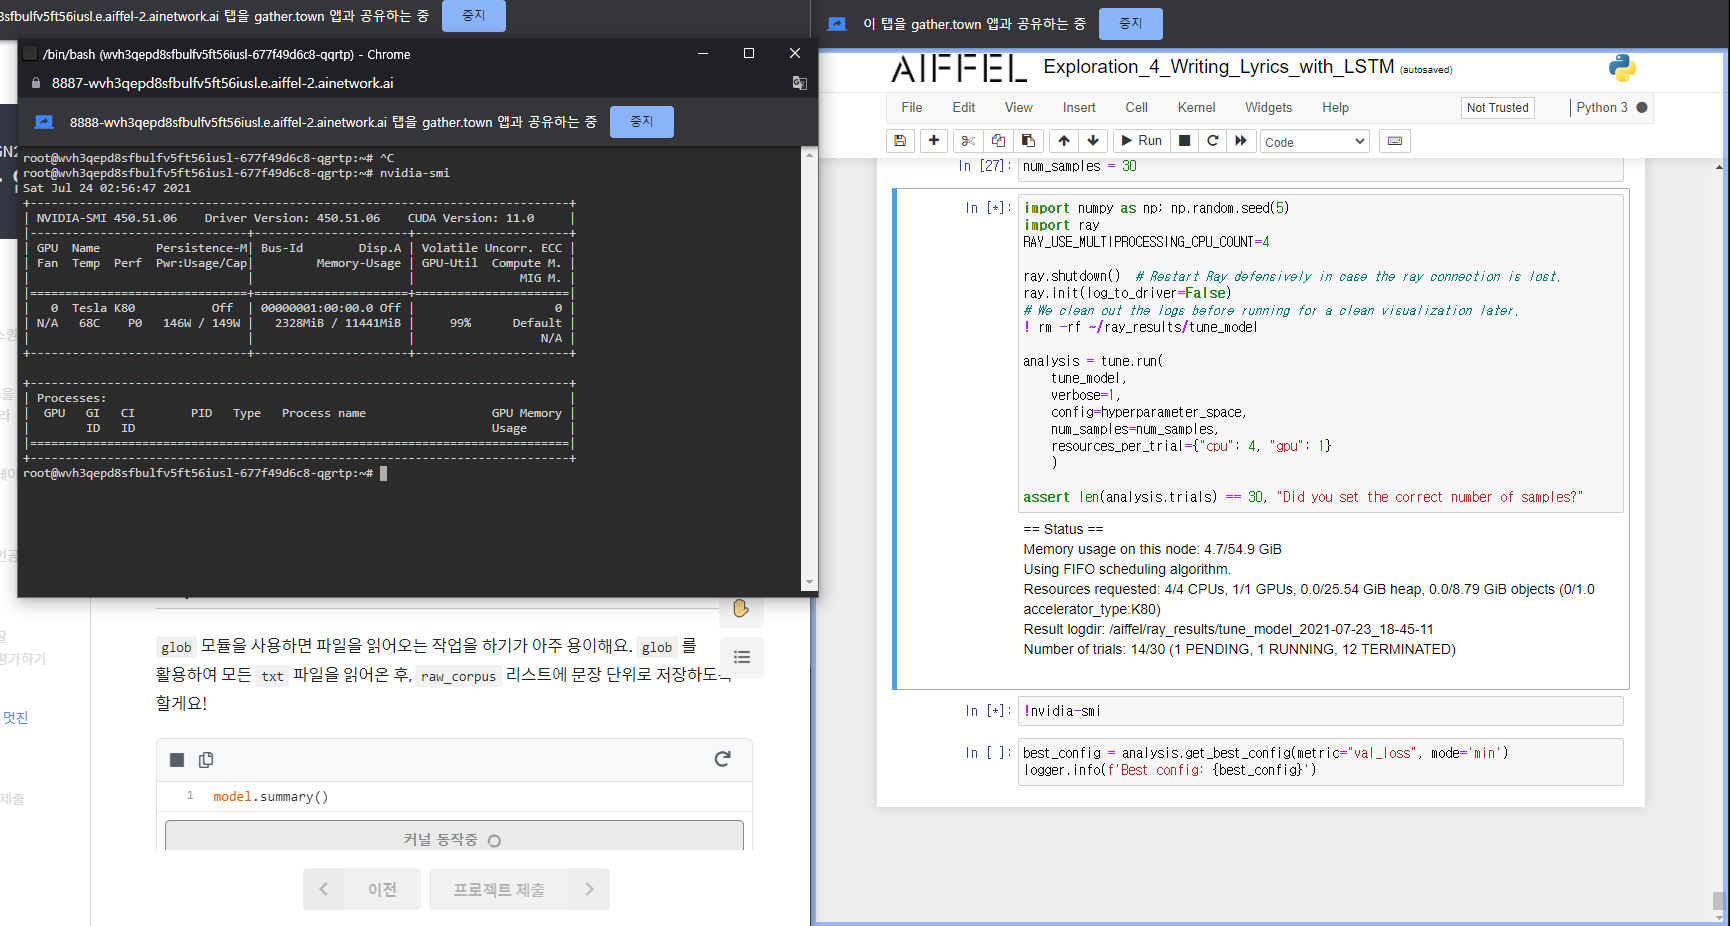

각각 1000개, 250개의 데이터 포인트를 가지는 train_set(dataset_exp_5)과 val_set(dataset_exp_val)으로도 시도해본다. 이 때, 실험용 데이터셋이 원래의 데이터셋을 잘 대표할 가능성은 낮다.

In [24]:
import numpy as np; np.random.seed(5)
from ray.tune import JupyterNotebookReporter
from ray.tune.suggest.basic_variant import BasicVariantGenerator


RAY_USE_MULTIPROCESSING_CPU_COUNT=4
reporter = JupyterNotebookReporter(overwrite=True)
reporter.add_metric_column("val_loss")


ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
#! rm -rf ~/aiffel/000Projects/EX4_data/ray_results


analysis = ray.tune.run(
    tune_exp_model,
    metric="val_loss",
    verbose=2, 
    config=hyperparameter_space,
    num_samples=num_samples,
    resources_per_trial={"cpu": 4, "gpu": 1},
    progress_reporter=reporter,
    local_dir="~/aiffel/000Projects/EX4_data/ray_results_exp"
    )

assert len(analysis.trials) == 30, "Did you set the correct number of samples?"

Trial name,status,loc,embedding_size,hidden_size,lr,acc,loss,iter,total time (s),val_loss
tune_exp_model_7fa8e_00000,TERMINATED,,317,1190,0.0067376,0.505357,2.7978,10,66.8278,4.12692
tune_exp_model_7fa8e_00001,TERMINATED,,201,1224,0.0109757,0.424071,4.10096,10,64.5281,5.06323
tune_exp_model_7fa8e_00002,TERMINATED,,240,862,0.00278565,0.507286,2.84579,10,49.4152,3.97472
tune_exp_model_7fa8e_00003,TERMINATED,,332,1329,0.0146505,0.494143,3.22371,10,75.7609,4.32958
tune_exp_model_7fa8e_00004,TERMINATED,,208,219,0.00251416,0.497,3.34002,10,25.1071,4.13086
tune_exp_model_7fa8e_00005,TERMINATED,,331,1281,0.0132951,0.495929,3.32775,10,75.137,4.30462
tune_exp_model_7fa8e_00006,TERMINATED,,214,338,0.0264101,0.496214,3.23905,10,31.1345,4.24375
tune_exp_model_7fa8e_00007,TERMINATED,,265,233,0.00895279,0.522429,2.69982,10,25.3547,3.97058
tune_exp_model_7fa8e_00008,TERMINATED,,338,295,0.0148149,0.516643,2.74659,10,29.175,3.98812
tune_exp_model_7fa8e_00009,TERMINATED,,133,960,0.00861211,0.519857,2.65132,10,47.6605,4.06254


2021-07-24 15:11:16,419	INFO tune.py:448 -- Total run time: 1672.49 seconds (1671.40 seconds for the tuning loop).


In [26]:
best_config = analysis.get_best_config(metric="val_loss", mode='min')
print(f'Best config: {best_config}')

Best config: {'lr': 0.00027147819062335767, 'embedding_size': 417, 'hidden_size': 921, 'num_gpus': 1}


작은 search space에서도 시도해본다.

In [27]:
hyperparameter_space_1 = {
    "lr": tune.loguniform(0.00027, 0.0027),  
    "embedding_size": tune.randint(400, 450),
    "hidden_size": tune.randint(900, 1100),
    "num_gpus": 1
}

In [28]:
import numpy as np; np.random.seed(5)
from ray.tune import JupyterNotebookReporter
from ray.tune.suggest.basic_variant import BasicVariantGenerator


RAY_USE_MULTIPROCESSING_CPU_COUNT=4
reporter = JupyterNotebookReporter(overwrite=True)
reporter.add_metric_column("val_loss")


ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
#! rm -rf ~/aiffel/000Projects/EX4_data/ray_results


analysis = ray.tune.run(
    tune_exp_model,
    metric="val_loss",
    verbose=2, 
    config=hyperparameter_space_1,
    num_samples=num_samples,
    resources_per_trial={"cpu": 4, "gpu": 1},
    progress_reporter=reporter,
    local_dir="~/aiffel/000Projects/EX4_data/ray_results_exp"
    )

assert len(analysis.trials) == 30, "Did you set the correct number of samples?"

Trial name,status,loc,embedding_size,hidden_size,lr,acc,loss,iter,total time (s),val_loss
tune_exp_model_45c75_00000,TERMINATED,,447,1089,0.00045015,0.4985,3.05787,10,73.4484,3.94819
tune_exp_model_45c75_00001,TERMINATED,,416,973,0.000434593,0.497286,3.0679,10,61.5479,3.93399
tune_exp_model_45c75_00002,TERMINATED,,439,1090,0.000831333,0.503571,2.94157,10,70.871,3.98165
tune_exp_model_45c75_00003,TERMINATED,,430,907,0.00157497,0.508643,2.87399,10,65.1031,4.03837
tune_exp_model_45c75_00004,TERMINATED,,449,1081,0.00264353,0.515429,2.67702,10,69.3109,4.0766
tune_exp_model_45c75_00005,TERMINATED,,427,944,0.00120454,0.504286,2.91904,10,65.3673,3.98989
tune_exp_model_45c75_00006,TERMINATED,,401,1075,0.000471959,0.497071,3.05442,10,66.3917,3.94899
tune_exp_model_45c75_00007,TERMINATED,,422,1025,0.00034855,0.496214,3.10726,10,71.0487,3.90915
tune_exp_model_45c75_00008,TERMINATED,,409,1006,0.000355189,0.496429,3.10416,10,64.1679,3.90604
tune_exp_model_45c75_00009,TERMINATED,,401,1003,0.00102613,0.504643,2.93424,10,60.4627,3.99642


2021-07-24 16:19:54,985	INFO tune.py:448 -- Total run time: 2022.59 seconds (2022.48 seconds for the tuning loop).


In [35]:
searched_model = create_model(embedding_size=426, hidden_size=931, lr=0.00027138)
train_set = create_dataset(enc_train, dec_train)
val_set = create_dataset(enc_val, dec_val)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_426_931.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

searched_model.fit(train_set, validation_data=val_set, epochs=10, callbacks=callbacks)

NameError: name 'create_model' is not defined

10 epoch 안에 2.2의 val_loss에 도달하지 못한다. 모델의 변화를 줘 본다

## Bidirection and dropout

In [2]:
import tensorflow as tf

In [233]:
import tensorflow.keras.layers


class TextGeneratorLN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.bid_rnn_1 = tf.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(hidden_size, return_sequences=True, dropout=0.1, recurrent_dropout=0.05), merge_mode="concat")
        self.bid_rnn_2 = tf.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(hidden_size, return_sequences=True, dropout=0.1, recurrent_dropout=0.05), merge_mode="concat")
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.bid_rnn_1(out)
        out = self.bid_rnn_2(out)
        out = self.linear(out)
        
        return out

In [240]:
tokenizer.num_words

20000

In [234]:
def create_model_ln(*, embedding_size, hidden_size, lr, vocab_size=tokenizer.num_words+1):
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture'''
    
    optimizer = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
    reduction='none'
    )
    
    model = TextGeneratorLN(vocab_size, embedding_size, hidden_size)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [235]:
train_set = create_dataset(enc_train, dec_train)
val_set = create_dataset(enc_val, dec_val)

In [236]:
bid_model = create_model_ln(embedding_size=320, hidden_size=512, lr=0.0035)
train_set = create_dataset(enc_train, dec_train)
val_set = create_dataset(enc_val, dec_val)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='bid_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]
bid_model.fit(train_set, validation_data=val_set, epochs=10, callbacks=callbacks)

Epoch 1/10
929/929 [==============================] - 375s 397ms/step - loss: 2.6509 - accuracy: 0.6156 - val_loss: 0.5010 - val_accuracy: 0.9268
Epoch 2/10
929/929 [==============================] - 368s 396ms/step - loss: 0.3543 - accuracy: 0.9454 - val_loss: 0.1620 - val_accuracy: 0.9754
Epoch 3/10
929/929 [==============================] - 368s 396ms/step - loss: 0.0850 - accuracy: 0.9852 - val_loss: 0.0871 - val_accuracy: 0.9865
Epoch 4/10
929/929 [==============================] - 368s 396ms/step - loss: 0.0226 - accuracy: 0.9963 - val_loss: 0.0666 - val_accuracy: 0.9897
Epoch 5/10
929/929 [==============================] - 368s 396ms/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 0.0569 - val_accuracy: 0.9913
Epoch 6/10
929/929 [==============================] - 368s 396ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.0559 - val_accuracy: 0.9914
Epoch 7/10
929/929 [==============================] - 368s 396ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0664 -

bidirectional model의 경우, lr=0.07의 경우 val_loss가 낮게 나왔는데, 거의 대부분의 경우 생성을 포기하고 전부 padding으로 예측하였다. 따라서 작사가로서의 기능을 하지 못했다.
lr=0.0035로 진행할 시 역시 마찬가지였다.

In [285]:
generate_text(bid_model, init_sentence="<start> falling", max_len=20)

'<start> falling <end> '

In [286]:
generate_text(bid_model, init_sentence="<start> hey", max_len=20)

'<start> hey <end> '

# 모델 두 가지의 생성 결과 비교

### 두 번째로 성능이 좋았던 모델(embedding_size=350, hidden_size=900)을 new_model로 불러와 원래의 모델 lyricist와 생성을 비교한다.

In [58]:
new_model = create_model(embedding_size=350, hidden_size=900, lr=0.00288)
new_model.build((128,14))

In [60]:
new_model.summary()
new_model.load_weights("EX4_data/best_model_350_900.h5")

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     multiple                  7000350   
_________________________________________________________________
lstm_22 (LSTM)               multiple                  4503600   
_________________________________________________________________
lstm_23 (LSTM)               multiple                  6483600   
_________________________________________________________________
dense_11 (Dense)             multiple                  18020901  
Total params: 36,008,451
Trainable params: 36,008,451
Non-trainable params: 0
_________________________________________________________________


In [253]:
def generate_text(model, tokenizer=tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model.predict(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [254]:
generate_text(new_model, init_sentence="<start> i like", max_len=20)

"<start> i like the way how you' re lovin' me <end> "

In [76]:
generate_text(new_model, init_sentence="<start> i don'", max_len=20)

"<start> i don' t know what to do <end> "

In [77]:
generate_text(new_model, init_sentence="<start> you know what", max_len=20)

'<start> you know what it is when you make me believe <end> '

In [78]:
generate_text(new_model, init_sentence="<start> i believe", max_len=20)

'<start> i believe i can fly <end> '

In [81]:
generate_text(new_model, init_sentence="<start> i think", max_len=20)

"<start> i think i' m crazy <end> "

In [84]:
generate_text(new_model, init_sentence="<start> i can see", max_len=20)

'<start> i can see the colour of your kids <end> '

In [85]:
generate_text(new_model, init_sentence="<start> my son", max_len=20)

"<start> my son , i can' t see <end> "

In [89]:
generate_text(new_model, init_sentence="<start> kiss you", max_len=20)

'<start> kiss you taste you all night <end> '

In [91]:
generate_text(new_model, init_sentence="<start> be crazy ", max_len=20)

'<start> be crazy , wrong and warm <end> '

In [93]:
generate_text(new_model, init_sentence="<start> steal your heart", max_len=20)

'<start> steal your heart to the top <end> '

In [95]:
generate_text(new_model, init_sentence="<start> besides", max_len=20)

'<start> besides the world that i had to share <end> '

In [102]:
generate_text(new_model, init_sentence="<start> wonderful", max_len=20)

'<start> wonderful time for us to die <end> '

In [104]:
generate_text(new_model, init_sentence="<start> every day", max_len=20)

'<start> every day create your history <end> '

In [106]:
generate_text(new_model, init_sentence="<start> one day", max_len=20)

"<start> one day i' ll know <end> "

In [123]:
generate_text(new_model, init_sentence="<start> try to ", max_len=20)

'<start> try to get the screenshot and get some space <end> '

In [118]:
generate_text(new_model, init_sentence="<start> sing a song", max_len=20)

'<start> sing a song for me applejack , applejack <end> '

In [114]:
generate_text(new_model, init_sentence="<start> falling", max_len=20)

'<start> falling for your love <end> '

In [135]:
generate_text(new_model, init_sentence="<start> fly me", max_len=20)

'<start> fly me to the moon <end> '

In [134]:
generate_text(new_model, init_sentence="<start> get up", max_len=20)

'<start> get up , stand up <end> '

In [130]:
generate_text(new_model, init_sentence="<start> make a smile", max_len=20)

'<start> make a smile take care of the projects <end> '

In [142]:
generate_text(new_model, init_sentence="<start> please , don' t", max_len=20)

"<start> please , don' t you know that you' re gonna have to serve <end> "

In [144]:
generate_text(new_model, init_sentence="<start> i' m gonna", max_len=20)

"<start> i' m gonna make you believe <end> "

In [147]:
generate_text(new_model, init_sentence="<start> nobody", max_len=20)

'<start> nobody knows , nobody knows , nobody knows <end> '

In [148]:
generate_text(new_model, init_sentence="<start> apple", max_len=20)

'<start> apple are jumping up the hill <end> '

In [149]:
generate_text(new_model, init_sentence="<start> sweet", max_len=20)

'<start> sweet revenge <end> '

In [151]:
generate_text(new_model, init_sentence="<start> tired", max_len=20)

"<start> tired of this lie you' re telling me no more <end> "

In [157]:
generate_text(new_model, init_sentence="<start> my god", max_len=20)

"<start> my god , i don' t care <end> "

In [167]:
generate_text(new_model, init_sentence="<start> your place", max_len=20)

'<start> your place is just like me <end> '

In [168]:
generate_text(new_model, init_sentence="<start> await", max_len=20)

'<start> await the light of the night <end> '

In [169]:
generate_text(new_model, init_sentence="<start> vacation", max_len=20)

'<start> vacation to get a little taller <end> '

In [172]:
generate_text(new_model, init_sentence="<start> in the forest , ", max_len=20)

'<start> in the forest , in the pines <end> '

In [174]:
generate_text(new_model, init_sentence="<start> look at the", max_len=20)

"<start> look at the world , it' s the way you do <end> "

In [175]:
generate_text(new_model, init_sentence="<start> i have", max_len=20)

'<start> i have been so good to you <end> '

In [176]:
generate_text(new_model, init_sentence="<start> wounded", max_len=20)

'<start> wounded plans , plans , like a pirate drop <end> '

In [184]:
generate_text(new_model, init_sentence="<start> your phone", max_len=20)

'<start> your phone is a flood of rubies <end> '

In [187]:
generate_text(new_model, init_sentence="<start> lucky", max_len=20)

'<start> lucky lefty of a pen <end> '

In [200]:
generate_text(lyricist, init_sentence="<start> my god", max_len=20)

"<start> my god , i don' t wanna be the one , manning <end> "

In [201]:
generate_text(lyricist, init_sentence="<start> i have", max_len=20)

'<start> i have porno stars and spouses <end> '

In [202]:
generate_text(lyricist, init_sentence="<start> tired", max_len=20)

"<start> tired of this lie you' re telling i won' t <end> "

In [203]:
generate_text(lyricist, init_sentence="<start> i' m gonna", max_len=20)

"<start> i' m gonna be good to you <end> "

In [204]:
generate_text(lyricist, init_sentence="<start> look at the", max_len=20)

'<start> look at the owl on the floor <end> '

# 회고

1. 전처리에서 '를 잘 처리하는 방법을 고심했다. 결과적으로 어퍼스트로피를 잘 표현하는 모델을 갖게 된 것 같아 뿌듯하다.
2. 5번 미만의 시도에서 운 좋게 val_loss가 2.2 미만인 모델(lyricist, val_loss=1.6)을 얻었다. 그럼에도 계속 여러 모델을 학습시켜 본 것은, lyricist를 학습할 당시 val_loss를 모니터하지 않아 기준을 성취한 것을 몰라서이며, 이것을 알게 된 것은 많은 수의 수작업 트라이얼과, ray라는 모듈을 새로 배워서 밤새 서치를 돌렸지만 원하는 결과를 얻지 못하고 bidirectional model의 val_loss가 좋게 나왔으나 뒤를 이미 아는 부분만 맞게 예측한 후 end 토큰을 빠르게 반환하는 전략임을 알고 포기하려는 마음을 먹은 후였다.
3. 하이퍼파라미터 튜닝은 생각보다 매우 고되었고, bidirectional 모델의 경우 모든 것을 보고 아는 것을 적고 end를 출력하여 제대로 된 문장을 만들지 않는단 것은 놀라웠다. 